### Bibliotecas

In [90]:
#%pip install ipykernel plotly
#%pip install ipykernel nbformat>=4.2.0
#%pip install ipykernel pandas
#%pip install ipykernel numpy
#%pip install ipykernel seaborn
#%pip install ipykernel openpyxl

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.ticker as ticker
from datetime import date, datetime
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
def ler_arquivo_csv(nome_arquivo:str, sep:str, id_cols:list, id_slice:int, normal = True) -> pd.DataFrame:
      """ 
      A função recebe como input: 
            - o nome do arquivo, 
            - o tipo de separador (;/, etc...), 
            - o id_slice se refere ao índice da posição da primeira coluna de ano (lembrando que  1a coluna corresponde a 0)
            - normal = True quando a base não tem anos repetidos (valor default). Colocar False quando for o caso.
      """
      
      base_raw = pd.read_csv(f'C:\\Users\\victorien.nago_ifood\\Downloads\\Pos_Fiap\\{nome_arquivo}.csv', 
                             sep = sep, 
                             encoding = 'utf-8', 
                             thousands = '.', 
                             decimal = ','
                         )
      
      cols = base_raw.columns

      if normal:
            base_cleaned = (base_raw 
                            .melt(id_vars = id_cols, 
                                  value_vars = cols[id_slice:],
                                  var_name = 'ano',
                                  value_name = 'volume'
                              )
                        )
      else:

            base_quantidade = (base_raw[id_cols + [col for col in cols if len(col) == 4 and col != 'País']]
                              .melt(id_vars = id_cols, 
                                    value_vars = [col for col in cols if len(col) == 4],
                                    var_name = 'ano',
                                    value_name = 'volume'
                                    )
                              )
            
            base_grana = (base_raw[id_cols + [col for col in cols if len(col) == 6]]
                         .melt(id_vars = id_cols, 
                              value_vars = [col for col in cols if len(col) == 6],
                              var_name = 'ano',
                              value_name = 'valor_usd'
                              )
                        )
            base_grana['ano'] = base_grana['ano'].str.replace('.1', '')

            base_cleaned = pd.merge(base_quantidade, base_grana, on = ['Id', 'País', 'ano'], how = 'inner')


      return base_cleaned

### Leitura e Tratamento das bases

#### Bases de processamento

In [16]:
bases_processamento_sem_classificacao = ler_arquivo_csv('Processamento - Sem classificacao','\t', ['id',	'control', 'cultivar'],  3)
bases_processamento_viniferas  = ler_arquivo_csv('Processamento - Viniferas', ';', ['id',	'control', 'cultivar'], 3) 
bases_processamento_mesa  = ler_arquivo_csv('Processamento - Mesa', '\t', ['id',	'control', 'cultivar'], 3) 
bases_processamento_americana_hibridos  = ler_arquivo_csv('Processamento - Americanas & Hibridos', '\t', ['id',	'control', 'cultivar'], 3)  

In [156]:
bases_processamento_sem_classificacao.head()

,id,control,cultivar,ano,volume
0,1,sc,Sem classificação,1970,3675463
1,1,sc,Sem classificação,1971,665425
2,1,sc,Sem classificação,1972,197232
3,1,sc,Sem classificação,1973,491357
4,1,sc,Sem classificação,1974,57307


#### Bases de Exportação

In [85]:
bases_exportacao_espumantes  = ler_arquivo_csv('Exportação - Espumantes', ';', ['Id', 'País'], 2, False) 
bases_exportacao_suco  = ler_arquivo_csv('Exportação - Suco', ';', ['Id', 'País'], 2, False) 
bases_exportacao_uva  = ler_arquivo_csv('Exportação - Uva', ';', ['Id', 'País'], 2, False) 
bases_exportacao_vinho  = ler_arquivo_csv('Exportação - Vinho', ';', ['Id', 'País'], 2, False) 

In [38]:
bases_exportacao_vinho.head()

,Id,País,ano,volume,valor_usd
0,1,Afeganistão,1970,0,0
1,2,África do Sul,1970,0,0
2,3,"Alemanha, República Democrática",1970,0,0
3,4,Angola,1970,0,0
4,5,Anguilla,1970,0,0


In [91]:
bases_exportacao_vinho.to_excel("bases_exportacao_vinho.xlsx")  

In [86]:
export_vinho_agg = (bases_exportacao_vinho
                    .groupby(['País', 'ano'])[['volume', 'valor_usd']]
                    .sum()
                    .reset_index()
                    .sort_values(by='ano')                
                )

export_vinho_agg['valor_por_litro'] = round(export_vinho_agg['volume']/export_vinho_agg['valor_usd'], 2)
export_vinho_agg.fillna(0, inplace = True)
export_vinho_agg[export_vinho_agg['País'].isin(['Rússia', 'Paraguai', 'Estados Unidos'])]

,País,ano,volume,valor_usd,valor_por_litro
2592,Estados Unidos,1970,11200,4200,2.67
5940,Rússia,1970,0,0,0.00
5400,Paraguai,1970,89846,23980,3.75
2593,Estados Unidos,1971,22400,8400,2.67
5401,Paraguai,1971,237805,64075,3.71
...,...,...,...,...,...
2644,Estados Unidos,2022,220373,447893,0.49
5992,Rússia,2022,66046,118618,0.56
2645,Estados Unidos,2023,229839,429091,0.54
5453,Paraguai,2023,3780378,5517263,0.69


In [87]:
fig = px.line(export_vinho_agg[export_vinho_agg['País'].isin(['Rússia', 'Paraguai', 'Estados Unidos'])], 
             x = 'ano', 
             y = 'valor_por_litro',
             color = 'País', 
             title = "Valor por litro ao longo dos anos"
            )

fig.update_layout(
    width = 1000,   
    height = 500,  
    xaxis_tickangle = -45,  # Rotacionar os rótulos do eixo X em -45 graus
    xaxis_title = "Ano",
    yaxis_title = "Valor por litro"
)

#fig.update_yaxes(tickformat = ",")  # separadores de milhares para exibir números inteiros
fig.show()

In [65]:
bases_exportacao_vinho.query("País == 'Afeganistão' ").head(100)

,Id,País,ano,volume
0,1,Afeganistão,1970,0
137,1,Afeganistão,1970.1,0
274,1,Afeganistão,1971,0
411,1,Afeganistão,1971.1,0
548,1,Afeganistão,1972,0
...,...,...,...,...
13015,1,Afeganistão,2017.1,0
13152,1,Afeganistão,2018,0
13289,1,Afeganistão,2018.1,0
13426,1,Afeganistão,2019,0


#### Bases de Importação

In [18]:
bases_importacao_espumantes  = ler_arquivo_csv('Importação - Espumantes', ';', ['Id', 'País'], 2, False) 
bases_importacao_frescas  = ler_arquivo_csv('Importação - Frescas', ';', ['Id', 'País'], 2, False) 
bases_importacao_passas  = ler_arquivo_csv('Importação - Passas', ';', ['Id', 'País'], 2, False) 
bases_importacao_suco  = ler_arquivo_csv('Importação - Suco', ';', ['Id', 'País'], 2, False) 
bases_importacao_vinhos  = ler_arquivo_csv('Importação - Vinhos', ';', ['Id', 'País'], 2, False) 

In [24]:
bases_importacao_vinhos['País']

np.int64(0)

In [19]:
bases_importacao_vinhos.head()

,Id,País,ano,volume,valor_usd
0,1,Africa do Sul,1970,0,0.0
1,2,Alemanha,1970,52297,30498.0
2,3,Argélia,1970,0,0.0
3,4,Arábia Saudita,1970,0,0.0
4,5,Argentina,1970,19525,12260.0


#### Base de producao

In [18]:
base_producao  = ler_arquivo_csv('Producao', ';', ['id','control', 'produto'], 3) 

In [163]:
base_producao.head()

,id,control,produto,ano,volume
0,1,VINHO DE MESA,VINHO DE MESA,1970,217208604
1,2,vm_Tinto,Tinto,1970,174224052
2,3,vm_Branco,Branco,1970,748400
3,4,vm_Rosado,Rosado,1970,42236152
4,5,VINHO FINO DE MESA (VINIFERA),VINHO FINO DE MESA (VINIFERA),1970,23899346


#### Base de comercializaçao

In [19]:
base_comercializacao  = ler_arquivo_csv('Comercialização', ';', ['id',	'control', 'Produto'], 3) 

In [20]:
base_comercializacao['ano'] = pd.to_datetime(base_comercializacao['ano'], format='%Y').dt.year
base_comercializacao.head()

,id,control,Produto,ano,volume
0,1,VINHO DE MESA,VINHO DE MESA,1970,98327606
1,2,vm_Tinto,Tinto,1970,83300735
2,3,vm_Rosado,Rosado,1970,107681
3,4,vm_Branco,Branco,1970,14919190
4,5,VINHO FINO DE MESA,VINHO FINO DE MESA,1970,4430629


In [34]:
agrupado = base_comercializacao.groupby(['Produto'])[['volume']].sum()
agrupado = agrupado.reset_index().sort_values(by='volume', ascending=False)
agrupado['categoria'] = np.where(
                        agrupado['Produto'].str.lower().str.contains('vinho'), 'Vinhos',
                        np.where(agrupado['Produto'].str.lower().str.contains('espumante'), 'Espumantes',
                        np.where(agrupado['Produto'].str.lower().str.contains('suco'), 'Sucos', 
                        np.where(agrupado['Produto'].str.strip().isin(['Tinto', 'Branco', 'Rosado']), 'Vinhos', 
                                 agrupado['Produto'])))
                        )            
agrupado.head()

,Produto,volume,categoria
52,VINHO DE MESA,9722978897,Vinhos
37,Tinto,8606251506,Vinhos
10,Branco,2066709639,Vinhos
49,SUCO DE UVAS,1826086400,Sucos
51,VINHO FINO DE MESA,1430272879,Vinhos


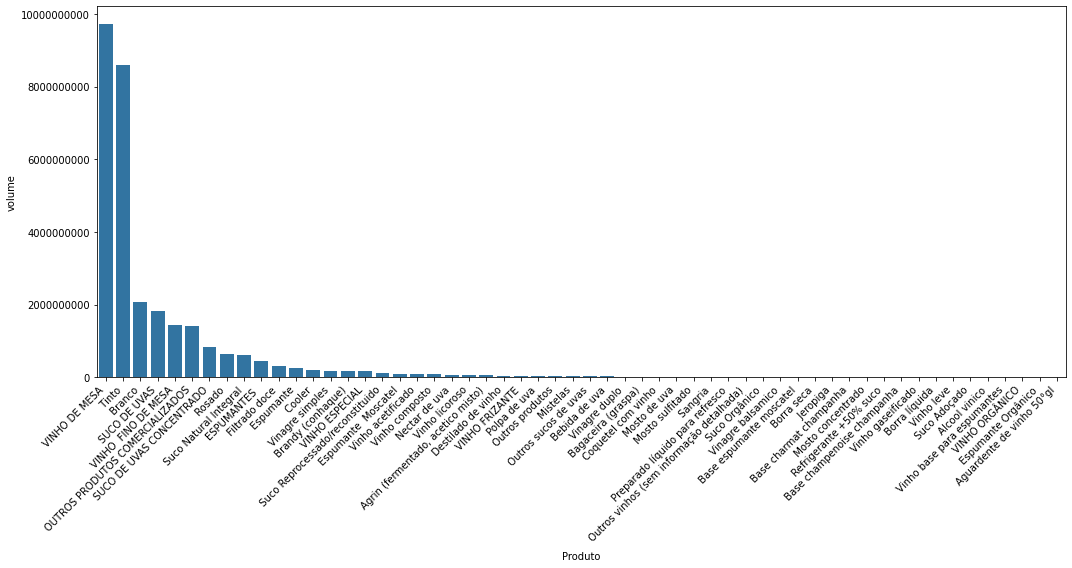

In [189]:
plt.figure(figsize=(15, 8)) #Tamanho do gráfico
sns.barplot(data=agrupado, x = 'Produto', y = 'volume')
plt.xticks(rotation=45, ha='right')  # Rotaciona os ticks do eixo X para 45 graus e alinha para a direita
ax = plt.gca()  # Obter o eixo atual
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))  # Desativa a notação científica
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()  # Ajusta automaticamente o layout para evitar sobreposições
plt.show()

In [188]:
fig = px.bar(agrupado, x = 'Produto', y = 'volume', title = "Volume comercializado por produto")
fig.update_layout(
    width = 1500,   
    height = 800,  
    xaxis_tickangle = -45,  # Rotacionar os rótulos do eixo X em -45 graus
    xaxis_title = "Produto",
    yaxis_title = "Volume"
)

fig.update_yaxes(tickformat = ",")  # separadores de milhares para exibir números inteiros
fig.show()

#### Vinhos

In [ ]:
#.agg(quantidade_total = pd.NamedAgg(column="volume", aggfunc="sum"), 
# valor_total = pd.NamedAgg(column="volume", aggfunc="sum"),
#)

In [35]:
import plotly.graph_objects as go

#### Importação e exportação ao longo dos anos

In [66]:
base_export_agg = (bases_exportacao_vinho
                   .query("ano >= '2008' ")
                   .groupby('ano')[['volume', 'valor_usd']]
                   .sum()
                   .reset_index()
                )

base_export_agg['media_volume'] = round(base_export_agg['volume'].mean(), 2)
base_export_agg['media_valor'] = round(base_export_agg['valor_usd'].mean(), 2)

In [37]:
base_import_agg = (bases_importacao_vinhos
                   .groupby('ano')[['volume', 'valor_usd']]
                   .sum()
                   .reset_index()
                )

base_import_agg['media_volume'] = round(base_import_agg['volume'].mean(), 2)
base_import_agg['media_valor'] = round(base_import_agg['valor_usd'].mean(), 2)

In [34]:
base_export_agg.head()

,ano,volume,valor_usd,media_volume,media_valor
0,1970,136009,40500,4705130.44,4652204.72
1,1971,281305,83465,4705130.44,4652204.72
2,1972,381020,121097,4705130.44,4652204.72
3,1973,471270,174792,4705130.44,4652204.72
4,1974,356985,185871,4705130.44,4652204.72


In [61]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=base_export_agg['ano'], 
                         y=base_export_agg['volume'], 
                         name='Quantidade exportada',
                         yaxis='y1',
                         line=dict(color='firebrick', 
                                   width=4)
                        )
                )

fig.add_trace(go.Scatter(x=base_import_agg['ano'], 
                         y=base_import_agg['volume'], 
                         name='Quantidade importada',
                         yaxis= 'y2',
                         line=dict(color='royalblue', 
                                   width=4)
                        )
                )
fig.update_layout(
    yaxis=dict(
        title='Quantidade exportada',
        titlefont=dict(color='red'),
        tickfont=dict(color='red')
    ),
    yaxis2=dict(
        title='Quantidade importada',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
        overlaying='y',
        side='right'
    ),
    title='Quantidade exportada vs Quantidade importada',
    xaxis_title='Ano'
    #,yaxis_title='Quantidade(L)'
    )

In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=base_export_agg['ano'], 
                         y=base_export_agg['valor_usd'], 
                         name='Total exportado em usd',
                         yaxis='y1',
                         line=dict(color='firebrick', 
                                   width=4)
                        )
                )

fig.add_trace(go.Scatter(x=base_import_agg['ano'], 
                         y=base_import_agg['valor_usd'], 
                         name='Total importada em usd',
                         yaxis='y2',
                         line=dict(color='royalblue', 
                                   width=4)
                        )
                )
fig.update_layout(
    yaxis=dict(
        title='Total exportado em usd',
        titlefont=dict(color='red'),
        tickfont=dict(color='red')
    ),
    yaxis2=dict(
        title='Total importado em usd',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
        overlaying='y',
        side='right'
    ),
    title='Total exportado em usd vs Total importado em usd',
    #width = 1000,   
    #height = 500,
    xaxis_title='Ano'
    #,yaxis_title='Valor(USD)'
)

#### Importação e exportação por país

In [78]:
bases_exportacao_vinho['País_categoria'] = np.where(
                                            bases_exportacao_vinho['País'].isin(['Rússia', 'França', 'Paraguai', 'Estados Unidos', 'China', 'Espanha']),
                                            bases_exportacao_vinho['País'], 
                                                  'outros'
                                                )

base_export_agg_pais = (bases_exportacao_vinho
                        .query("ano >= '2008' ")
                        .groupby('País_categoria')[['volume', 'valor_usd']]
                        .sum()
                        .reset_index()
                     )

In [80]:
base_export_agg_pais.head(10)

,País_categoria,volume,valor_usd
0,China,2583375,4929621
1,Espanha,1993180,3812723
2,Estados Unidos,3793194,10113658
3,França,319818,735081
4,Paraguai,32995148,44236294
5,Rússia,39029799,25504484
6,outros,12806806,32235531


In [77]:
base_export_agg_pais = (bases_exportacao_vinho
                        .query("ano >= '2008' ")
                        .groupby('País')[['volume', 'valor_usd']]
                        .sum()
                        .reset_index()
                     )

base_export_agg_pais_by_volume = base_export_agg_pais.sort_values(by='volume', ascending=False).head(10)
base_export_agg_pais_by_valor = base_export_agg_pais.sort_values(by='valor_usd', ascending=False).head(10)

In [64]:
fig = px.bar(
        base_export_agg_pais_by_volume, 
        x = 'País', 
        y = 'volume', 
        text_auto='.2s',
        title = "Top 10 país exportadores em quantidade"
    )
fig.update_layout(
    width = 1000,   
    height = 500,  
    xaxis_tickangle = -45,  # Rotacionar os rótulos do eixo X em -45 graus
    xaxis_title = "País",
    yaxis_title = "Quantidade"
)

fig.show()

In [71]:
fig = px.bar(
        base_export_agg_pais_by_valor, 
        x = 'País', y = 'valor_usd', 
        text_auto='.2s',
        title = "Top 10 país exportadores em dollars"
    )

fig.update_layout(
    width = 1000,   
    height = 500,  
    xaxis_tickangle = -45,  # Rotacionar os rótulos do eixo X em -45 graus
    xaxis_title = "País",
    yaxis_title = "valor_usd"
)

fig.show()

In [69]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=base_export_agg['ano'],
    y=base_export_agg['volume'],
    #text_auto='.2s',
    name='Quantidade',
    marker=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=base_export_agg['ano'],
    y=base_export_agg['valor_usd'],
    name='valor em usd',
    yaxis='y2',
    mode='lines+markers',
    line=dict(color='red')
))

fig.update_layout(
    yaxis=dict(
        title='Quantidade',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='Valor em usd',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    title='Quantidade e valor de exportação',
)

In [81]:
base_export_agg_pais['quantidade_total'] = base_export_agg_pais['volume'].sum()
base_export_agg_pais['valor_usd_total'] = base_export_agg_pais['valor_usd'].sum()
base_export_agg_pais['share_quantidade'] = base_export_agg_pais['volume']/base_export_agg_pais['quantidade_total'] 
base_export_agg_pais['share_valor_usd'] = base_export_agg_pais['valor_usd']/base_export_agg_pais['valor_usd_total'] 
base_export_agg_pais

In [82]:
base_export_agg_pais.head()

,País_categoria,volume,valor_usd,quantidade_total,valor_usd_total,share_quantidade,share_valor_usd
0,China,2583375,4929621,93521320,121567392,0.027623,0.040551
1,Espanha,1993180,3812723,93521320,121567392,0.021313,0.031363
2,Estados Unidos,3793194,10113658,93521320,121567392,0.040560,0.083194
3,França,319818,735081,93521320,121567392,0.003420,0.006047
4,Paraguai,32995148,44236294,93521320,121567392,0.352809,0.363883


In [84]:
fig = px.pie(base_export_agg_pais, 
             values='share_quantidade', 
             names='País_categoria', 
             title='Share da quantidade'
            )
fig.update_layout(
    width = 1000,   
    height = 500 
    )
fig.show()

In [ ]:
base_export_agg_pais = (bases_exportacao_vinho
                        .query("ano >= '2008' ")
                        .groupby('País')[['volume', 'valor_usd']]
                        .sum()
                        .reset_index()
                     )